<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [47]:
!pip install tacoreader rasterio

2025-10-22 16:02:34,060 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4316].


image size (13, 512, 512)
label size (1, 512, 512)


Text(0.5, 1.0, 'Dataset label')

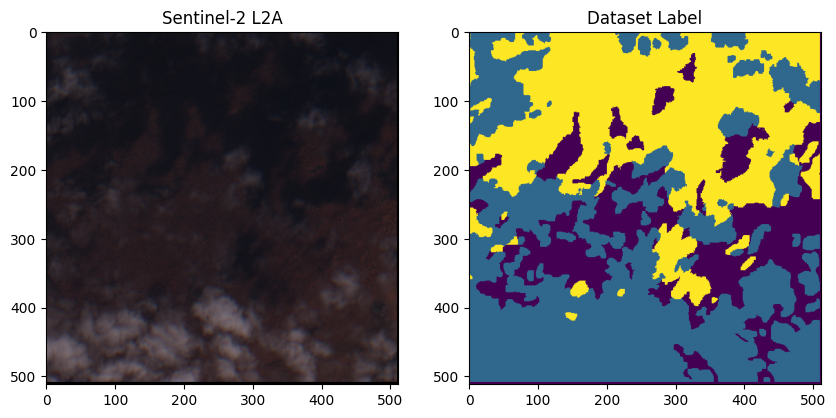

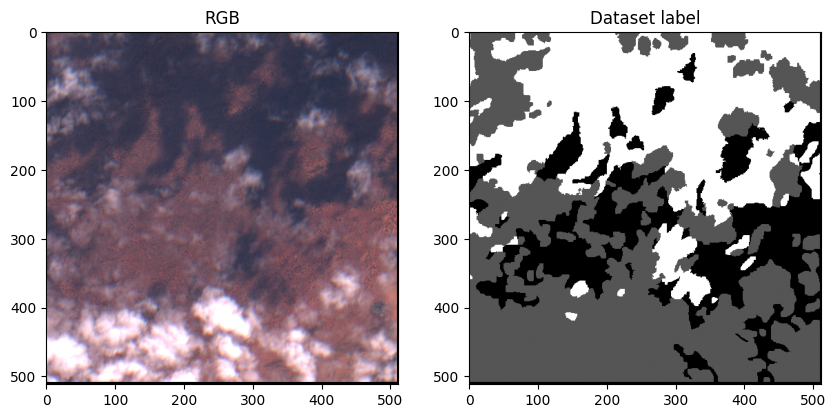

In [48]:
# Setup and accessing CloudSEN12+
# TODO REWRITE WHOLE SECTION - COPIED

import logging
import matplotlib.pyplot
import numpy
import tacoreader
import rasterio as rio
import torch
import torch.nn as nn

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
# todo remove
# subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 272
s2_l1c = ds.read(sample_idx).read(0)
s2_label = ds.read(sample_idx).read(1)

# Debug iteration
with rio.open(s2_l1c), rio.open(s2_label):
    # s2_l1c_data = rio.open(s2_l1c).read(window = rio.windows.Window(0, 0, 508, 508)) / 10000
    # s2_label_data = rio.open(s2_label).read(window = rio.windows.Window(0, 0, 508, 508))
    s2_l1c_data = rio.open(s2_l1c).read(window = rio.windows.Window(0, 0, 512, 512)) / 10000
    s2_label_data = rio.open(s2_label).read(window = rio.windows.Window(0, 0, 512, 512))
    print("image size", s2_l1c_data.shape) #todo - clipped to 13, 508, 508
    print("label size", s2_label_data.shape) #todo - clipped to 1, 508, 508

# TODO make more colour representative - find what channel represents what
# Combine selective channels to form RGB image - source: https://sciencenotes.org/visible-light-spectrum-wavelengths-and-colors/
# red         625 - 700 nm
# green       500 - 565 nm
# light blue  484 - 500 nm
# dark blue   450 - 484 nm

# B02 Blue - 496.5 nm - 53.0 nm index 1
# B03 Green- 560.0 nm - 34.0 nm index 2
# B03 Red  - 664.5 nm - 29.0 nm index 3
# see https://huggingface.co/datasets/tacofoundation/cloudsen12
rgb = numpy.dstack((
    s2_l1c_data[3][:][:],
    s2_l1c_data[2][:][:],
    s2_l1c_data[1][:][:]
  ))
rgb_manual = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3

# Display
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(rgb)
ax[0].set_title("Sentinel-2 L2A")
ax[1].imshow(s2_label_data[0], cmap = "viridis") # see https://matplotlib.org/stable/users/explain/colors/colormaps.html
ax[1].set_title("Dataset Label")


rgb_manual = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Dataset label")


In [49]:
# initalise and set up the logger application
logger = logging.getLogger(__name__)

logging.basicConfig(
    #filename = "logging.txt",  # logger is saved to file instead of shown on the console
    encoding = "ASCII",
    format = "%(asctime)s %(name)s %(levelname)s:\t%(message)s",
    level = logging.INFO,
    force = True
)

# Selecting either a GPU or CPU to run system on
if torch.cuda.is_available():
  device = torch.device("cuda") # For GPU operation
else:
  device = torch.device("cpu")
logger.info(f"The pyTorch code will be ran on the {device = }.")

2025-10-22 16:02:35,994 __main__ INFO:	The pyTorch code will be ran on the device = device(type='cuda').


## Misc Functions

### tensor_info()

In [50]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  logger.info(f"Tensor:\t\t\t{tensor_name}")
  logger.info(f"Output Datatype:\t{tensor_input.dtype}")
  logger.info(f"Output Shape:\t\t{tensor_input.shape}")
  logger.info(f"Output Size:\t\t{tensor_input.size()}")
  logger.info(f"Output Device:\t\t{tensor_input.device}"
      f"\n--------------------------------------------------------\n")
  return None

### mash_colour_channel()

In [51]:
def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]. \
      2D images can also used used in format [x, y] or [u, v]

  return:
    None
  """
  # uses ".unsqueeze(0)" to add an extra dimension for 2D images.
  if img.dim() == 2:
    img = img.unsqueeze(0)

  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  # Move the tensor to CPU (if on Cuda/GPU) before converting to numpy
  img = img.detach().cpu().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # print the image
  if z_size == 13:
    logger.debug("verified 13 channel image (raw image input)")
    # create a grey scale and colour scale image - todo be further extensively modified
    fig, ax = matplotlib.pyplot.subplots(1, 2, figsize = (10, 5))

    img_colour = numpy.moveaxis(img[[3, 2, 1]], 0, -1) * 3 # need to further investigate todo

    ax[0].set_title("greyscale img")
    ax[0].imshow(img_no_colour)
    ax[1].set_title("coloured img")
    ax[1].imshow(img_colour)

  else:
    logger.debug("verified as non-13 channel image/label") # just determine the greyscale image
    # Change label depending on image size
    if z_size == 1:
      text = "1 channel data (label)"
    else:
      text = "non-standard data"

    fig = matplotlib.pyplot.figure() # create a new figure to seperate output from previous data
    matplotlib.pyplot.gray() # place the image output into greyscale
    fig.suptitle(text)
    matplotlib.pyplot.imshow(img_no_colour)
    matplotlib.pyplot.show()

  # display image dimension characteristics
  logger.info(f"The image resolution is {img_no_colour.shape}")
  logger.info(f"The number of colour channels are {z_size}")
  return None

# U-net Model Definition


### conv_layer(nn.Module)

In [52]:
# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels
class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in, up_sample = True): # Parameters go here!
    super().__init__()

    if up_sample:
      if channels_in == 13:
        out_channels = 64
      else:
        out_channels = channels_in * 2
    else:
      out_channels = int(channels_in / 2)

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    ).to(device)
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = out_channels,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        padding = 1,
        dtype = torch.float32
    ).to(device)
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU().to(device)

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


### decoder_layer(nn.Module)

In [53]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_deconv_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_deconv_in,
        out_channels = int(channels_deconv_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    logger.debug(f"size_difference = {size_difference}")
    logger.debug(f"img_encoder_skip.shape = {img_decoder.shape}")
    logger.debug(f"img_decoder.shape = {img_decoder.shape}")

    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      logger.debug(f"The image dimensions are EVEN. Thus cropping can be applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      # tensor_info(img_decoder, "[ORIGINAL] img_decoder")
      # tensor_info(img_encoder_crop, "[CROPPED] img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      # tensor_info(img_concat, "[COMBINED] img_concat (combined colour channels)")
      # mash_colour_channel(img_concat)

      return img_concat

    else:
      logger.info(f"The image dimensions are ODD. Thus cropped can NOT be applied."
        f"Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img_decoder, img_encoder_skip, channels_in):
    # deconvolute (decrease features, increasing x,y size) + crop and concatenate (x2 feature channels)
    output = self.deconv1(img_decoder)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in, up_sample = False)
    output = conv_layer_1(output)
    return output

## Bringing it all together

### u_net(nn.Module)

In [54]:
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

class u_net(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Applies the U-net architecture complete via prior defined piecemeal functions.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, ):
    super().__init__()
    # ---------------------------------------------------------
    # Instantiate and initialise each layer
    # Encoder Layer instantiation
    self.encoder_layer_1 = encoder_layer().to(device)
    # Bottleneck Layer instantiation
    self.bottleneck_layer = conv_layer(channels_in = 512).to(device)
    # Decoders instantiation
    self.decoder_layer_0 = decoder_layer(channels_deconv_in = 1024).to(device)
    self.decoder_layer_1 = decoder_layer(channels_deconv_in = 512).to(device)
    self.decoder_layer_2 = decoder_layer(channels_deconv_in = 256).to(device)
    self.decoder_layer_3 = decoder_layer(channels_deconv_in = 128).to(device)
    self.decoder_layer_4 = decoder_layer(channels_deconv_in = 64).to(device)
    # Final Layer instantiation
    self.final_layer = conv_layer(channels_in = 64, up_sample = False).to(device)
    # ---------------------------------------------------------
    # TODO - remove if unneeded - included as debug 08.10.2025
    self.flatten_final_layer = nn.Conv2d(
          in_channels = 32,
          out_channels = 1,
          kernel_size = 3,
          stride = 1,
          padding = 1,
    ).to(device)

  def forward(self, img):

    # Apply image to instantiated layers
    # Encoder layer
    A_pooled, A_concat = self.encoder_layer_1(img, channels_in = 13)
    B_pooled, B_concat = self.encoder_layer_1(A_pooled, channels_in = 64)
    C_pooled, C_concat = self.encoder_layer_1(B_pooled, channels_in = 128)
    D_pooled, D_concat = self.encoder_layer_1(C_pooled, channels_in = 256)

    # Bottleneck layer
    E_bottleneck = self.bottleneck_layer(D_pooled)

    # Decoder Layer
    D_deconv = self.decoder_layer_0(
        img_decoder = E_bottleneck,
        img_encoder_skip = D_concat,
        channels_in = 1024
    )
    C_deconv = self.decoder_layer_1(
        img_decoder = D_deconv,
        img_encoder_skip = C_concat,
        channels_in = 512
    )
    B_deconv = self.decoder_layer_2(
        img_decoder = C_deconv,
        img_encoder_skip = B_concat,
        channels_in = 256
    )
    A_deconv = self.decoder_layer_3(
        img_decoder = B_deconv,
        img_encoder_skip = A_concat,
        channels_in = 128
    )
    # Final Layer
    Final_output = self.final_layer(A_deconv)
    Final_output = self.flatten_final_layer(Final_output) # todo 08.10.2025 addition



    return Final_output

In [55]:
input = s2_l1c_data
input = torch.from_numpy(input)

input = input.type(torch.float32)
input = input.to(device)
tensor_info(input, "input")

e1 = encoder_layer().to(device)

e1.eval()
out1, out2 = e1(input, channels_in = 13)
tensor_info(out1, "out")
out1, out2 = e1(out1, channels_in = 64)
tensor_info(out1, "out")
out1, out2 = e1(out1, channels_in = 128)
tensor_info(out1, "out")
out1, out2 = e1(out1, channels_in = 256)
tensor_info(out1, "out")
out1, out2 = e1(out1, channels_in = 512)
tensor_info(out1, "out")
del out1, out2

2025-10-22 16:02:36,146 __main__ INFO:	Tensor:			input
2025-10-22 16:02:36,149 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:02:36,153 __main__ INFO:	Output Shape:		torch.Size([13, 512, 512])
2025-10-22 16:02:36,154 __main__ INFO:	Output Size:		torch.Size([13, 512, 512])
2025-10-22 16:02:36,156 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-22 16:02:36,163 __main__ INFO:	Tensor:			out
2025-10-22 16:02:36,166 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:02:36,167 __main__ INFO:	Output Shape:		torch.Size([64, 256, 256])
2025-10-22 16:02:36,170 __main__ INFO:	Output Size:		torch.Size([64, 256, 256])
2025-10-22 16:02:36,173 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-22 16:02:36,190 __main__ INFO:	Tensor:			out
2025-10-22 16:02:36,195 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:02:36,197 __main__ INFO:	Output Shape:		torch.Size([1

2025-10-22 16:02:36,886 __main__ INFO:	Tensor:			input
2025-10-22 16:02:36,887 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:02:36,888 __main__ INFO:	Output Shape:		torch.Size([13, 512, 512])
2025-10-22 16:02:36,890 __main__ INFO:	Output Size:		torch.Size([13, 512, 512])
2025-10-22 16:02:36,890 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-22 16:02:37,060 __main__ INFO:	Tensor:			out
2025-10-22 16:02:37,061 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:02:37,062 __main__ INFO:	Output Shape:		torch.Size([1, 512, 512])
2025-10-22 16:02:37,063 __main__ INFO:	Output Size:		torch.Size([1, 512, 512])
2025-10-22 16:02:37,064 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------



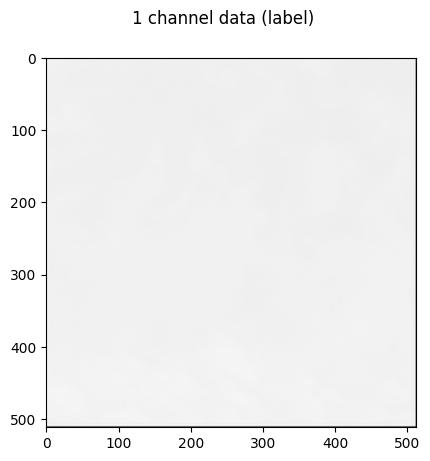

2025-10-22 16:02:37,243 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:02:37,244 __main__ INFO:	The number of colour channels are 1


In [56]:
# Sanity Check: Display u-net architecture's parameters
u_net_arch = u_net().to(device) # Reinitialise u_net model

# u_net_arch = UNET().to(device) # Reinitialise u_net model
# u_net_arch = UNet_medium().to(device) # Reinitialise u_net model

u_net_arch.eval()
# u_net.no_grad()


input = torch.from_numpy(s2_l1c_data)
input = input.type(torch.float32)
input = input.to(device)
tensor_info(input, "input")

#
out = u_net_arch(input)
#
tensor_info(out, "out")
mash_colour_channel(out)
del out

## Experiementation --

In [57]:
# Image preprocessing DEBUG - todo remove?
# s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
# s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
# s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# # Crop image such that after 8 convolutions are 4 poolings, so that the dimensions are always even
# # s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]

# # Apply everything via the U-net architecture
# u_net_arch = u_net().to(device)
# img_out = u_net_arch(s2_l1c_data_tensor)

# mash_colour_channel(img_out)
# mash_colour_channel(torch.tensor(s2_label_data))
# mash_colour_channel(s2_l1c_data_tensor)

In [58]:
# a cut down u-net model for testing



# can be used for differing tasks
# up and down convolutions
class UNET(nn.Module):
  def __init__(self):
    super().__init__()
    # Two convolutions and a ReLU
    self.conv1 = nn.Conv2d(
        in_channels = 13,
        out_channels = 26, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = 26,
        out_channels = 26,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Two convolutions and a ReLU
    self.conv3 = nn.Conv2d(
        in_channels = 26, # 26
        out_channels = 52, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv4 = nn.Conv2d(
        in_channels = 52,
        out_channels = 52,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Two convolutions and a ReLU
    self.conv5 = nn.Conv2d(
        in_channels = 52,
        out_channels = 104, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv6 = nn.Conv2d(
        in_channels = 104,
        out_channels = 104,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Two convolutions and a ReLU
    self.conv7 = nn.Conv2d(
        in_channels = 104,
        out_channels = 208, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv8 = nn.Conv2d(
        in_channels = 208,
        out_channels = 208,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv_bottleneck_1 = nn.Conv2d(
        in_channels = 208,
        out_channels = 416,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    self.conv_bottleneck_2 = nn.Conv2d(
        in_channels = 416,
        out_channels = 416,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU().to(device)

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

    ### D
    self.deconv1 = nn.ConvTranspose2d(
        in_channels = 416,
        out_channels = 208,
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

    self.conv1_de = nn.Conv2d(
        in_channels = 416,
        out_channels = 208, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv2_de = nn.Conv2d(
        in_channels = 208,
        out_channels = 208,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)
    ## C

    self.deconv2 = nn.ConvTranspose2d(
        in_channels = 208,
        out_channels = 104,
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

    self.conv3_de = nn.Conv2d(
        in_channels = 208,
        out_channels = 104, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv4_de = nn.Conv2d(
        in_channels = 104,
        out_channels = 104,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)
    # B

    self.deconv3 = nn.ConvTranspose2d(
        in_channels = 104,
        out_channels = 52,
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

    self.conv5_de = nn.Conv2d(
        in_channels = 104,
        out_channels = 52, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv6_de = nn.Conv2d(
        in_channels = 52,
        out_channels = 52,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)
    # C

    self.deconv4 = nn.ConvTranspose2d(
        in_channels = 52,
        out_channels = 26,
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

    self.conv7_de = nn.Conv2d(
        in_channels = 52,
        out_channels = 26, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv8_de = nn.Conv2d(
        in_channels = 26,
        out_channels = 26,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # B_concat
    self.deconv5 = nn.ConvTranspose2d(
        in_channels = 26,
        out_channels = 13,
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

    self.conv9_de = nn.Conv2d(
        in_channels = 26,
        out_channels = 13, # increase the size of the convolution
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    # Convolution 2 - a sliding window function
    self.conv10_de = nn.Conv2d(
        in_channels = 13,
        out_channels = 13,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)
    # flatten

    # Convolution 2 - a sliding window function
    self.conv_flat = nn.Conv2d(
        in_channels = 13,
        out_channels = 1,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)

    def forward(self, img):
      # Stage Z
      output = self.conv1(img)
      output = self.relu(output)
      output = self.conv2(output)
      output = self.relu(output)
      prepool_output1 = output
      postpool_output1 = self.pooling(output) # Final transformation to image
      # Stage A
      output = self.conv3(postpool_output1)
      output = self.relu(output)
      output = self.conv4(output)
      output = self.relu(output)
      prepool_output2 = output
      postpool_output2 = self.pooling(output) # Final transformation to image
      # Stage B
      output = self.conv5(postpool_output2)
      output = self.relu(output)
      output = self.conv6(output)
      output = self.relu(output)
      prepool_output3 = output
      postpool_output3 = self.pooling(output) # Final transformation to image
      # Stage C
      output = self.conv7(postpool_output3)
      output = self.relu(output)
      output = self.conv8(output)
      output = self.relu(output)
      prepool_output4 = output
      postpool_output4 = self.pooling(output) # Final transformation to image

      # Stage D/E - to bottleneck stage
      output = self.conv_bottleneck_1(postpool_output4)
      output = self.relu(output)
      output = self.conv_bottleneck_2(output)
      output = self.relu(output)

      # Decoder side
      # Stage D
      output = self.deconv1(output)
      temp_img = ttF.resize(prepool_output4, size = (output.size[1], output.size[2])) # crops the prepool image
      output = torch.cat(tensors = (output, temp_img), dim = 0)
      output = self.conv1_de(output)
      output = self.relu(output)
      output = self.conv2_de(output)
      output = self.relu(output)
      #
      output = self.deconv2(output)
      temp_img = ttF.resize(prepool_output3, size = (output.size[1], output.size[2])) # crops the prepool image
      output = torch.cat(tensors = (output, temp_img), dim = 0)
      output = self.conv3_de(output)
      output = self.relu(output)
      output = self.conv4_de(output)
      output = self.relu(output)
      #
      output = self.deconv3(output)
      temp_img = ttF.resize(prepool_output2, size = (output.size[1], output.size[2])) # crops the prepool image
      output = torch.cat(tensors = (output, temp_img), dim = 0)
      output = self.conv5_de(output)
      output = self.relu(output)
      output = self.conv6_de(output)
      output = self.relu(output)
      # A
      output = self.deconv4(output)
      temp_img = ttF.resize(prepool_output1, size = (output.size[1], output.size[2])) # crops the prepool image
      output = torch.cat(tensors = (output, temp_img), dim = 0)
      output = self.conv7_de(output)
      output = self.relu(output)
      output = self.conv8_de(output)
      output = self.relu(output)
      # Z - flatten
      output = self.conv_flat(output)

      return output

In [59]:
# sourced from https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114
# TODO remove - not my own work!!!
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = ttF.resize(x2, size = (x1.shape[1], x1.shape[2])) # crops the prepool image
        x = torch.cat([x1, x2], dim = 0)
        return self.conv(x)

class UNet_medium(nn.Module):
    def __init__(self): #, in_channels, num_classes):
        super().__init__()
        #self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_1 = DownSample(13, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        #self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

# Execution of Model

In [60]:
# Sanity Check: Display u-net architecture's parameters
u_net_arch = u_net().to(device) # Reinitialise u_net model

# u_net_arch = UNET().to(device) # Reinitialise u_net model
# u_net_arch = UNet_medium().to(device) # Reinitialise u_net model
logger.debug(f"{list(u_net_arch.parameters()) = }")

# Loading, Sorting, and Processing Training Stage Data


## Load Data 1

In [61]:
# Preparation for auto iterating and downloading requesite data
l1c_fileNames = [
    "cloudsen12-l1c.0000.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0001.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0002.part.taco", # --
    "cloudsen12-l1c.0003.part.taco", # --
    "cloudsen12-l1c.0004.part.taco"  # --
  ]

from huggingface_hub import hf_hub_download
import os

# Searches for imported datasets. If none are found download
if os.path.isfile("/content/datasets/cloudsen12-l1c.0001.part.taco") == False:
  logger.info(f"The requisite datasets have not been installed.\n\t\t\t\t\t"
      "Please wait until the datasets is been installed from huggingface.\n\t\t\t\t\t"
      "This will take a long time approximately 5+ minutes")

  # 20GB download requires significant time - execute sparingly takes roughly 5 minutes to fully execute
  # Downloads data from huggingface and stores it in Colab file system which is reset on every startup
  # dataset_0 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0000.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  # logger.info(f"cloudsen12-l1c.0000.part.taco has been installed.")
  # ----------------------------------------------------------------------------
  # TODO is this required?
  # dataset_1 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0001.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  logger.info(f"cloudsen12-l1c.0001.part.taco has been installed.")
  logger.info(f"The requisite datasets have been installed.")
else:
  logger.info(f"The requisite datasets have already been been installed.\n\t\t\t\t\t"
      "No further action is required.")
  # Ensure that the file is referenced in the local variable memory - TODO
  #with open("/content/datasets/cloudsen12-l1c.0000.part.taco") as file:
  #  exec(dataset1 = file)


# TODO
  # #from googleapiclient.http import MediaFileUpload
  # import googleapiclient
  # import googleapiclient.discovery
  # drive_service = googleapiclient.discovery.build('drive', 'v3')

  # file_metadata = {
  #   'name': 'cloud_training_data',
  #   'mimeType': 'text/plain'
  # }
  # media = googleapiclient.http.MediaFileUpload(
  #     '/content/datasets/cloudsen12-l1c.0000.part.taco',
  #     mimetype = 'text/plain',
  #     resumable = True
  #   )
  # created = drive_service.files().create(
  #     body=file_metadata,
  #     media_body=media,
  #     fields='id'
  #   ).execute()

  # print('File ID: {}'.format(created.get('id')))
  # #https://colab.research.google.com/notebooks/io.ipynb?hl=en#scrollTo=r5X77CZ5_G-C

2025-10-22 16:02:37,706 __main__ INFO:	The requisite datasets have not been installed.
					Please wait until the datasets is been installed from huggingface.
					This will take a long time approximately 5+ minutes
2025-10-22 16:02:37,707 __main__ INFO:	cloudsen12-l1c.0001.part.taco has been installed.
2025-10-22 16:02:37,708 __main__ INFO:	The requisite datasets have been installed.


## Load Data 2

In [62]:
# Load data into one massive variable - split afterwards into seperate training and testing data
# file = ["/content/datasets/cloudsen12-l1c.0000.part.taco", "/content/datasets/cloudsen12-l1c.0001.part.taco"]

# DATA = tacoreader.load(["/content/datasets/cloudsen12-l1c.0001.part.taco"])
# ds = DATA
DATA = tacoreader.load("tacofoundation:cloudsen12-l1c")

### extract_data()

2025-10-22 16:02:41,522 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0476].
2025-10-22 16:02:41,542 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:02:41,547 __main__ INFO:	The number of colour channels are 13


debug (13, 512, 512)
debug (1, 512, 512)


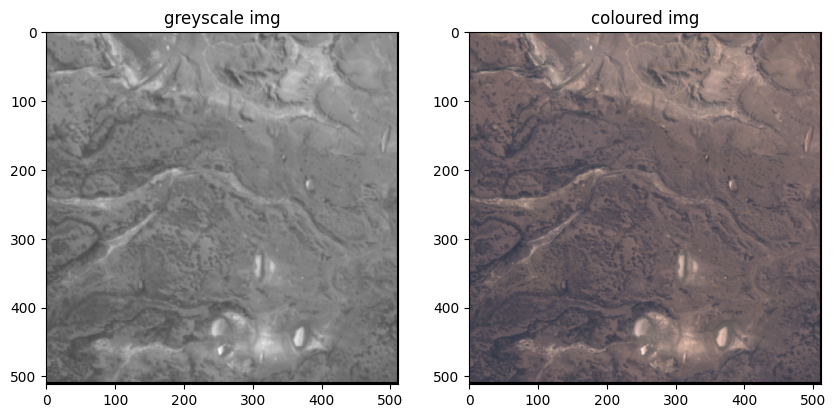

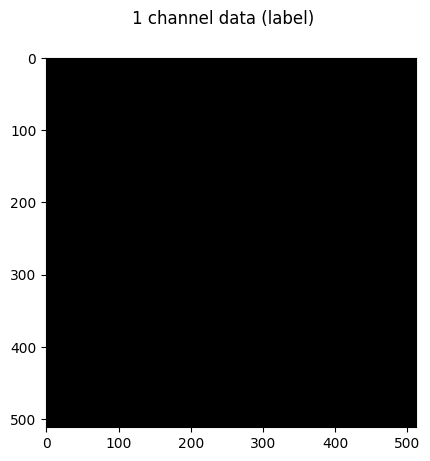

2025-10-22 16:02:43,492 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:02:43,495 __main__ INFO:	The number of colour channels are 1
2025-10-22 16:02:44,230 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.286].
2025-10-22 16:02:44,250 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:02:44,251 __main__ INFO:	The number of colour channels are 13


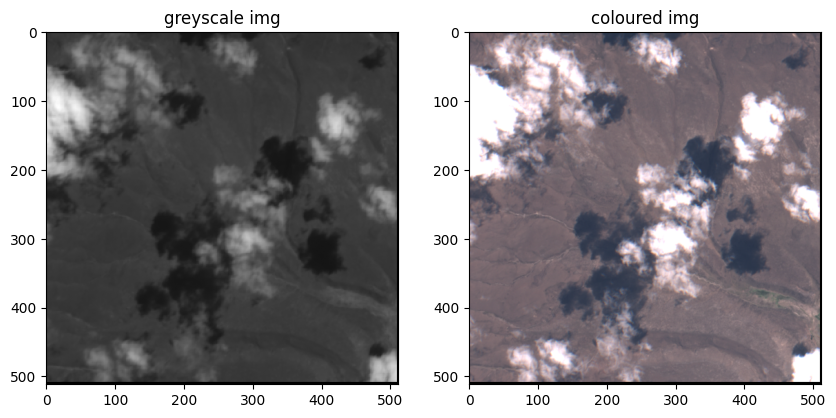

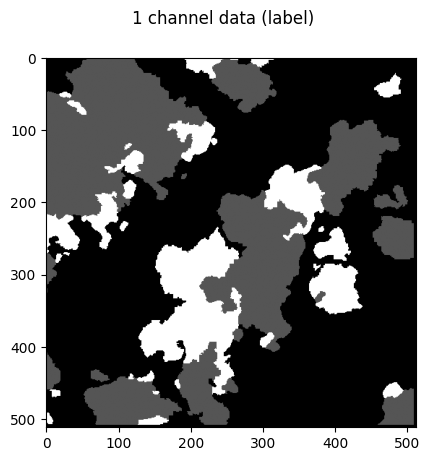

2025-10-22 16:02:45,143 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:02:45,144 __main__ INFO:	The number of colour channels are 1


In [63]:
def extract_data(sample_idx):
  """
  Reads only 1 sample from the saved DATA dataset  \
    Datatype, Shape, Size, and the device location stored in memory

  Args:
    sample_idx - a int index for the DATA variable. The DATA is stored in an \
    external scope. It has the whole dataset (training + testing) stored in it.

  return:
    s2_l1c_data - a [13 x 508 x 508] numpy array extracted from DATA
    s2_label_data - a [1 x 508 x 508] numpy array extracted from DATA
  """
  img_data = DATA.read(sample_idx).read(0)
  lbl_data = DATA.read(sample_idx).read(1)

  # Retrieve the data TODO remove
  # with rio.open(img_data) as src, rio.open(lbl_data) as dst:
      # s2_l1c_data = src.read([4, 3, 2],window = rio.windows.Window(0, 0, 512, 512))
      # s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))

  with rio.open(img_data), rio.open(lbl_data):
    # Image input is 508x508 pixels so that u-net works best
    # s2_l1c_data = rio.open(img_data).read(window = rio.windows.Window(0, 0, 508, 508)) / 10_000  # (13, 512, 512) ndarray (numpy)
    # s2_label_data = rio.open(lbl_data).read(window = rio.windows.Window(0, 0, 508, 508))
    s2_l1c_data = rio.open(img_data).read(window = rio.windows.Window(0, 0, 512, 512)) / 10_000  # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(lbl_data).read(window = rio.windows.Window(0, 0, 512, 512))

  # Output relevant datasets
  return s2_l1c_data, s2_label_data


# Debug and example output
img, label = extract_data(sample_idx = 4)

print("debug", numpy.shape(img))
print("debug", numpy.shape(label))
#
mash_colour_channel(torch.from_numpy(img))
mash_colour_channel(torch.from_numpy(label))

img, label = extract_data(sample_idx = 7)

mash_colour_channel(torch.from_numpy(img))
mash_colour_channel(torch.from_numpy(label))

label1 = numpy.squeeze(label)

## Sort Data

In [64]:
# The code done here follows the example methodologies shown in introduction to PyTorch

# Problem breakdown and requirements:

#   Need to import training data
#   -> breakdown into training and testing datasets
#   -> datasets must be cropped and converted into valid filetype
#   Need to import labels
#   -> datatype?
#   -> labels must be cropped and converted into valid filetype

# Need to evaluate success and labels

# WORK IN PROGRESS
#   Define the working datasets:
#   TODO CHECK DIMENSIONS
#   imported datasets are: img [z,x,y,i?], labels [x,y,i?]

#   Relies on assumptions of the quality of the imported data

# Train and testing ratio
DATASET_AMOUNT = 80 #80
tt_ratio = 0.8
TRAIN_AMOUNT = int(DATASET_AMOUNT * tt_ratio)
TEST_AMOUNT = DATASET_AMOUNT - TRAIN_AMOUNT

# Preallocate memory for traing and testing datasets
# train_img = numpy.empty(shape = (TRAIN_AMOUNT, 13, 508, 508))
train_img = numpy.empty(shape = (TRAIN_AMOUNT, 13, 512, 512))
train_img.fill(None)

# train_label = numpy.empty(shape = (TRAIN_AMOUNT, 508, 508))
train_label = numpy.empty(shape = (TRAIN_AMOUNT, 512, 512))
train_label.fill(None)

# test_img = numpy.empty(shape = (TEST_AMOUNT, 13, 508, 508,))
test_img = numpy.empty(shape = (TEST_AMOUNT, 13, 512, 512,))
test_img.fill(None)

# test_label = numpy.empty(shape = (TEST_AMOUNT, 508, 508,))
test_label = numpy.empty(shape = (TEST_AMOUNT, 512, 512,))
test_label.fill(None)

# Splits and seperates the data into traing and testing segments
for i in range(DATASET_AMOUNT):
  img_in, label_in = extract_data(sample_idx = i)
  label_in = numpy.where(
      numpy.logical_not(
          numpy.logical_or(label_in == 0, label_in == 3)), 0, 1)

  # store into training and testing
  if i < TRAIN_AMOUNT:
    train_img[i][:][:][:] = img_in
    train_label[i][:][:] = label_in
    logger.debug(f"{i} train")
  else:
    test_img[i - TRAIN_AMOUNT][:][:][:]  = img_in
    test_label[i  - TRAIN_AMOUNT][:][:] = label_in
    logger.debug(f"{i} test")

# Convert to tensors!
train_img = torch.from_numpy(train_img)
train_label = torch.from_numpy(train_label)
test_img = torch.from_numpy(test_img)
test_label = torch.from_numpy(test_label)
# Convert to standard float32 tensors! and move to operational device
train_img = train_img.to(torch.float32).to(device)
train_label = train_label.to(torch.float32).to(device)
test_img = test_img.to(torch.float32).to(device)
test_label = test_label.to(torch.float32).to(device)

# Resulting tensors
tensor_info(train_img, "combined train_img data")
tensor_info(train_label, "combined train_label data")
tensor_info(test_img, "combined test_img data")
tensor_info(train_label, "combined train_label data")

# -----------------------------------------------------------------------------------------------------------
# TODO Accessing data recommendations: "https://colab.research.google.com/drive/1U9n40rwdnn73bdWruONA3hIs1-H3f74Q"

2025-10-22 16:03:33,616 __main__ INFO:	Tensor:			combined train_img data
2025-10-22 16:03:33,617 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:03:33,617 __main__ INFO:	Output Shape:		torch.Size([64, 13, 512, 512])
2025-10-22 16:03:33,618 __main__ INFO:	Output Size:		torch.Size([64, 13, 512, 512])
2025-10-22 16:03:33,618 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-22 16:03:33,619 __main__ INFO:	Tensor:			combined train_label data
2025-10-22 16:03:33,620 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:03:33,620 __main__ INFO:	Output Shape:		torch.Size([64, 512, 512])
2025-10-22 16:03:33,621 __main__ INFO:	Output Size:		torch.Size([64, 512, 512])
2025-10-22 16:03:33,621 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-22 16:03:33,622 __main__ INFO:	Tensor:			combined test_img data
2025-10-22 16:03:33,623 __main__ INFO:	Output Datatype:	torch.float32


### view_img() -

In [65]:
# For Debug
def view_img(index_i, img_bundle, img_bundle_name):
  """
  Used for debug. Prints an index image from a image bundle (which is generated \
    from the DATA variable.

  Args:
    index_i (unsigned int) -  the index of the desired image from the bundle. \
      Please ensure the index is within the bundle's overall size (less than X).
    img_bundle (numpy array) - a collection of images (not labels) used for \
      training / testing. Dimensions are [X][Y][A][A]. X is amount of images, \
      Y is the no. channels, A is the image resolution (less than or equal to 508)
    img_bundle_names (str) - name of the bundle for debug

  return:
    None
  """
  tensor_info(img_bundle[index_i][:][:][:], "img_bundle_name " + str(index_i))
  mash_colour_channel(img_bundle[index_i][:][:][:])
  return None

# view_img(1, train_img, "train_img")
# view_img(7, test_img, "test_img")
# view_img(19, test_img, "test_img")
# view_img(79, train_img, "train_img")

### Dataset and Dataloader --

In [93]:
from torch.utils.data import Dataset, DataLoader

class cloud_dataset(Dataset):
    def __init__(self, train_image, train_label):
        self.images = train_img
        self.labels = train_label

    def __getitem__(self, idx):
        # Retrieve Datasets - need to insert proper codes
        image_out = torch.tensor(self.images[idx][:][:][:], dtype=torch.float32)
        label_out = torch.tensor(self.labels[idx][:][:], dtype=torch.float32)
        return image_out, label_out

    def __len__(self):
        return len(self.images)

train_loader = DataLoader(cloud_dataset(train_img, train_label), batch_size=8, shuffle=True)
test_loader = DataLoader(cloud_dataset(test_img, test_label), batch_size=8, shuffle=False)

In [66]:
u_net_arch = u_net().to(device) # Reinitialise u_net model
# u_net_arch = UNet_medium().to(device) # Reinitialise u_net model
logger.debug(f"{list(u_net_arch.parameters()) = }")

#debug
# img = train_img[12][:][:][:]
# train_predict = u_net_arch(img.to(device))

# mash_colour_channel(train_predict)
# mash_colour_channel(in1)
# histogram_tensor(train_predict, "genera. output")
# histogram_tensor(img, "actual. output")

tensor_info(train_img, "train img")
tensor_info(train_label, "train lbl")

2025-10-22 16:03:34,000 __main__ INFO:	Tensor:			train img
2025-10-22 16:03:34,001 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:03:34,002 __main__ INFO:	Output Shape:		torch.Size([64, 13, 512, 512])
2025-10-22 16:03:34,003 __main__ INFO:	Output Size:		torch.Size([64, 13, 512, 512])
2025-10-22 16:03:34,004 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-22 16:03:34,004 __main__ INFO:	Tensor:			train lbl
2025-10-22 16:03:34,006 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:03:34,006 __main__ INFO:	Output Shape:		torch.Size([64, 512, 512])
2025-10-22 16:03:34,007 __main__ INFO:	Output Size:		torch.Size([64, 512, 512])
2025-10-22 16:03:34,008 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------



# Inference Model

In [89]:
import tqdm
import torchvision.transforms.functional as ttF


TRAINING_LENGTH = TRAIN_AMOUNT
# TRAINING_LENGTH = 80 # CONTROLS NUMBER OF TRAINING CYCLES

# Allow for parameters of model to be randomised.
# weights = nn.Parameter(
#     torch.randn(1, dtype = torch.float32),
#     requires_grad = True
#   )

# loss and optimiser functions
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()

# optimiser_fn = torch.optim.SGD(
#     params = u_net_arch.parameters(), # parameters to be optimised
#     lr = 0.1 # learning rate (how much the optimizer should change parameters at each step, higher = more (less stable), lower = less (might take a long time))
# )
optimiser_fn = torch.optim.Adam(
    params = u_net_arch.parameters(), # parameters to be optimised
    lr = 0.01 # learning rate (how much the optimizer should change parameters at each step, higher = more (less stable), lower = less (might take a long time))
)

# todo remove debug
DATASET_AMOUNT = 20
TRAINING_LENGTH = 16
TEST_AMOUNT = 4



for i in range(8):
  losses = 0
  torch.manual_seed(27) # Seed for randomness - keeps the initial parameter values consistent
  u_net_arch.train() # In Training Mode - Default

  for epoch in tqdm.tqdm(range(TRAINING_LENGTH)):

    train_img_epoch = train_img[epoch][:][:][:].to(device)
    train_predict = u_net_arch(train_img_epoch) # intiial forward pass of model
    train_predict = torch.squeeze(train_predict) # make 2D, comparable to "training_label" # todo check dimension

    logger.info(f"{epoch=} {losses=}") # To observe the current status of the model
    train_label_epoch = train_label[epoch][:][:].type(torch.float32) #
    train_label_epoch = train_label_epoch.squeeze(0).to(device) # remove unnecessary dimension # todo clarify #

    loss = loss_fn(train_predict, train_label_epoch) # loss value is generated

    optimiser_fn.zero_grad() # optimised via zero grad

    loss.backward() # loss back propagation
    optimiser_fn.step() # progress the optimiser

    losses = losses + loss.item() * train_img_epoch.size(0)

    # need to find a more appropiate method of training data
    # original example had everything stored in one massive variable which was iterated through by the model
    # current setup requires manually iterating through each instance
    with torch.inference_mode():
      torch.no_grad()
      u_net_arch.eval() # Evaluate and test the model

      for test_epoch in range(TEST_AMOUNT):
        # 1. Forward pass on test data
        test_predict = u_net_arch(test_img[test_epoch][:][:][:])
        test_predict = torch.squeeze(test_predict) # make 2D, comparable to "training_label"

        # 2. Caculate loss on test data
        # 2.1 Resize "test_label" to match "test_pred's" dimensions # todo remove?
        test_label_epoch = test_label[test_epoch][:][:].type(torch.float32) #
        test_label_epoch = test_label_epoch.squeeze(0).to(device) # remove unnecessary dimension # todo clarify #

        # 2.2 Find loss of model
        test_loss = loss_fn(test_predict, test_label_epoch) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


In [81]:
import datetime
# Saves the generated model

# Find our model's learned parameters ONLY in debug mode
logger.debug("The model learned parameters:", u_net_arch.state_dict())

# Saves the model's learned parameters (state dictionary) to a file which is timestamped
if os.path.exists("/content/datasets/model_parameters") == False:
  os.mkdir("/content/datasets")
  os.mkdir("/content/datasets/model_parameters")

time_stamp = datetime.datetime.now().replace(microsecond = 0).isoformat() # prints out current ISO 8601 UTC time_stamp
u_net_model = "/content/datasets/model_parameters/u_net_" + str(time_stamp) + ".pt"
torch.save(u_net_arch.state_dict(), u_net_model)

# TODO to download state_dict to shorten exercution time 09.10.2025

# Model Evaluation

## Misc Evaluation Functions

### histogram_tensor() -

In [90]:
# todo create docstring
def histogram_tensor(img, img_name):
  # plots a histogram based on the image's min and max values
  # requires a tensor. Tensor is sent to the cpu regardless of original location
  # img (tensor X,Y) - img to be analyised, img_name - name of img for the graph


  # move to cpu location
  img_cpu = img
  img_cpu = img_cpu.cpu()

  # Get min and max values of the tensor as a float to develop the histogram
  min_val, max_val = torch.min(img_cpu).item(), torch.max(img_cpu).item()
  # print tensor details
  logger.info(f"{img_name} properties: \t min_val: {min_val}, max_val: {max_val}")
  tensor_info(img_cpu, img_name)

  bins_var = 100
  hist = torch.histc(img_cpu, bins = bins_var, min = min_val, max = max_val)

  # The scale is between min_val and max_val with the increment of bins_var
  x = range(bins_var)
  matplotlib.pyplot.figure()
  matplotlib.pyplot.title(img_name)
  matplotlib.pyplot.bar(x, hist, align='center')
  matplotlib.pyplot.xlabel('Bins')
  return None

## Evaluation

2025-10-22 16:42:13,980 __main__ INFO:	predicted mask 0 properties: 	 min_val: -0.4380643367767334, max_val: 6.5131001472473145
2025-10-22 16:42:13,981 __main__ INFO:	Tensor:			predicted mask 0
2025-10-22 16:42:13,982 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:13,983 __main__ INFO:	Output Shape:		torch.Size([1, 512, 512])
2025-10-22 16:42:13,983 __main__ INFO:	Output Size:		torch.Size([1, 512, 512])
2025-10-22 16:42:13,984 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-22 16:42:14,085 __main__ INFO:	original mask 0 properties: 	 min_val: 0.0, max_val: 1.0
2025-10-22 16:42:14,085 __main__ INFO:	Tensor:			original mask 0
2025-10-22 16:42:14,086 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:14,087 __main__ INFO:	Output Shape:		torch.Size([512, 512])
2025-10-22 16:42:14,088 __main__ INFO:	Output Size:		torch.Size([512, 512])
2025-10-22 16:42:14,088 __main__ INFO:	Output Device:		cpu
-----------------

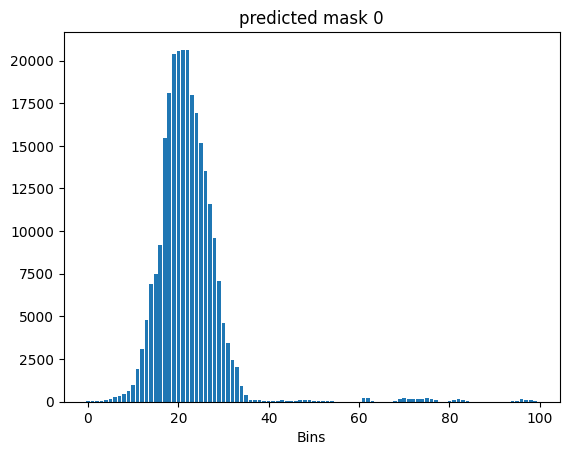

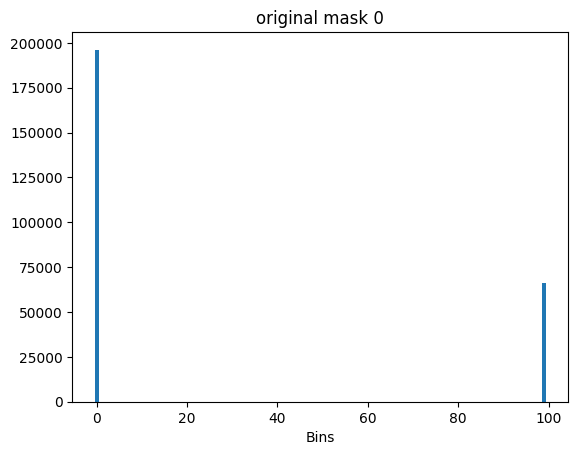

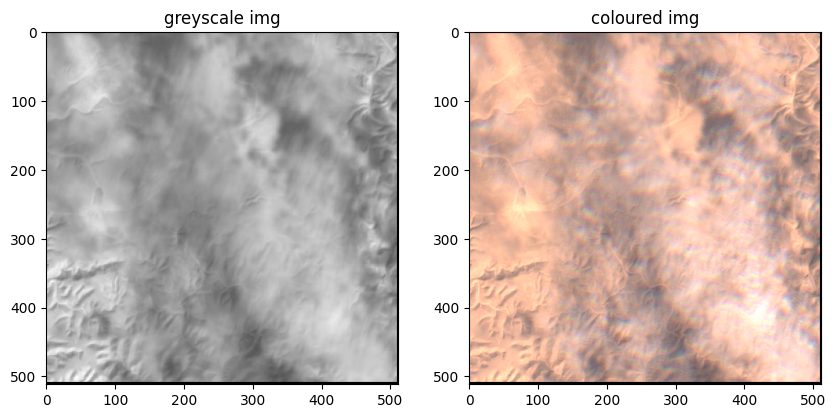

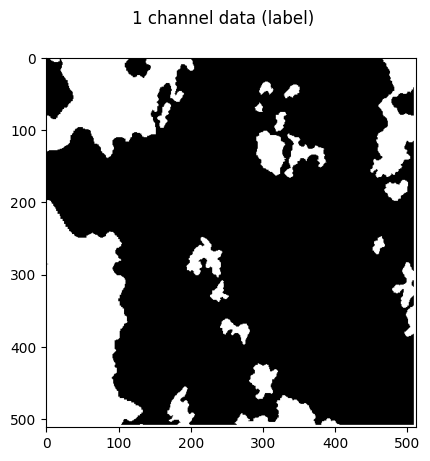

2025-10-22 16:42:15,293 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:15,294 __main__ INFO:	The number of colour channels are 1


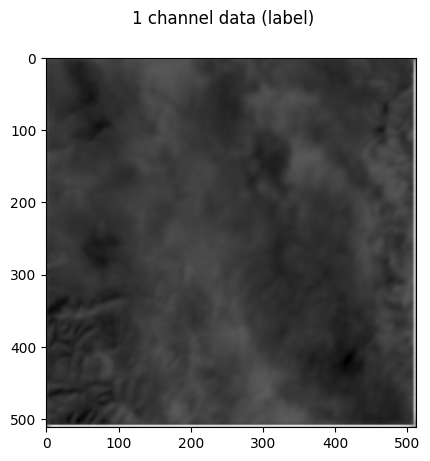

2025-10-22 16:42:15,538 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:15,539 __main__ INFO:	The number of colour channels are 1
2025-10-22 16:42:15,728 __main__ INFO:	predicted mask 1 properties: 	 min_val: 0.4951857328414917, max_val: 3.4151556491851807
2025-10-22 16:42:15,729 __main__ INFO:	Tensor:			predicted mask 1
2025-10-22 16:42:15,729 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:15,730 __main__ INFO:	Output Shape:		torch.Size([1, 512, 512])
2025-10-22 16:42:15,731 __main__ INFO:	Output Size:		torch.Size([1, 512, 512])
2025-10-22 16:42:15,734 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-22 16:42:15,824 __main__ INFO:	original mask 1 properties: 	 min_val: 1.0, max_val: 1.0
2025-10-22 16:42:15,824 __main__ INFO:	Tensor:			original mask 1
2025-10-22 16:42:15,826 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:15,827 __main__ INFO:	Output Shape:		torch.Size([512, 512])
2025

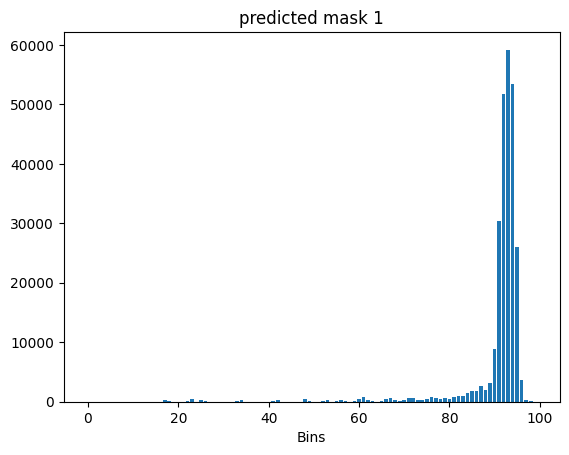

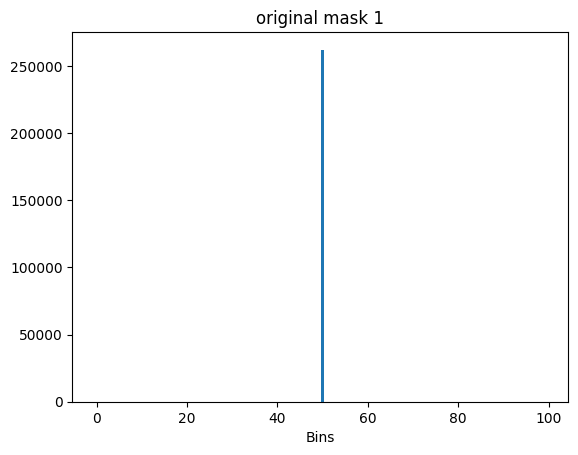

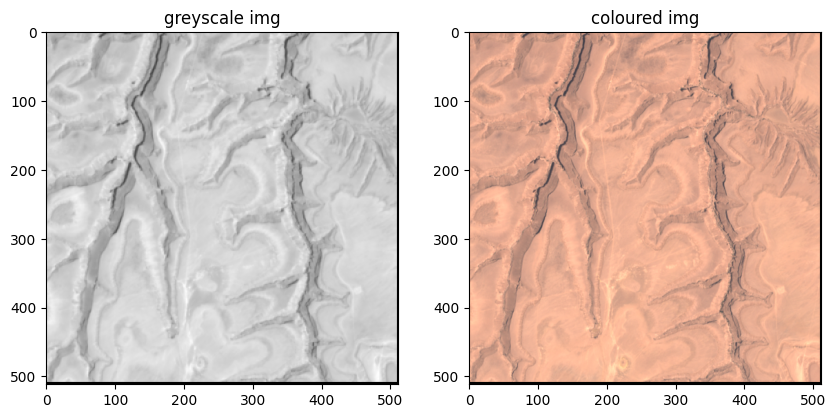

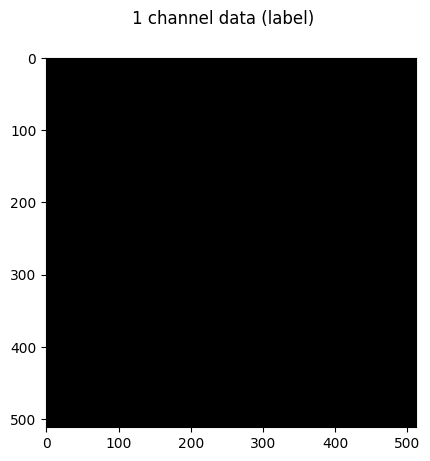

2025-10-22 16:42:16,966 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:16,967 __main__ INFO:	The number of colour channels are 1


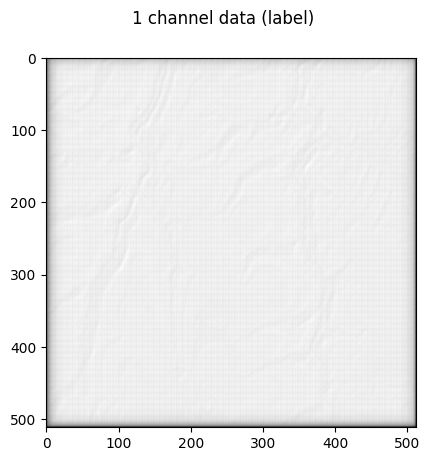

2025-10-22 16:42:17,138 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:17,139 __main__ INFO:	The number of colour channels are 1
2025-10-22 16:42:17,314 __main__ INFO:	predicted mask 2 properties: 	 min_val: 0.39251670241355896, max_val: 1.9607570171356201
2025-10-22 16:42:17,315 __main__ INFO:	Tensor:			predicted mask 2
2025-10-22 16:42:17,316 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:17,317 __main__ INFO:	Output Shape:		torch.Size([1, 512, 512])
2025-10-22 16:42:17,318 __main__ INFO:	Output Size:		torch.Size([1, 512, 512])
2025-10-22 16:42:17,321 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-22 16:42:17,425 __main__ INFO:	original mask 2 properties: 	 min_val: 0.0, max_val: 1.0
2025-10-22 16:42:17,426 __main__ INFO:	Tensor:			original mask 2
2025-10-22 16:42:17,426 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:17,428 __main__ INFO:	Output Shape:		torch.Size([512, 512])
202

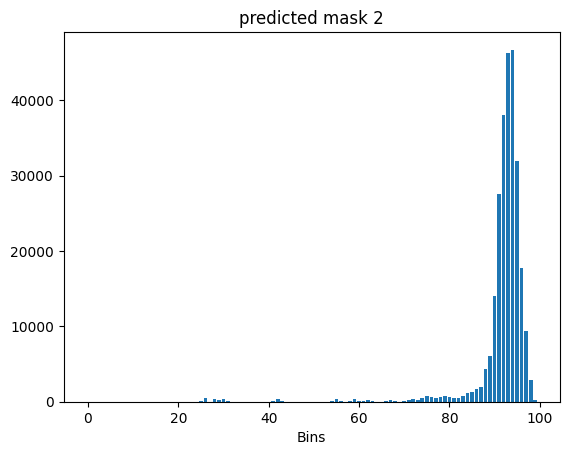

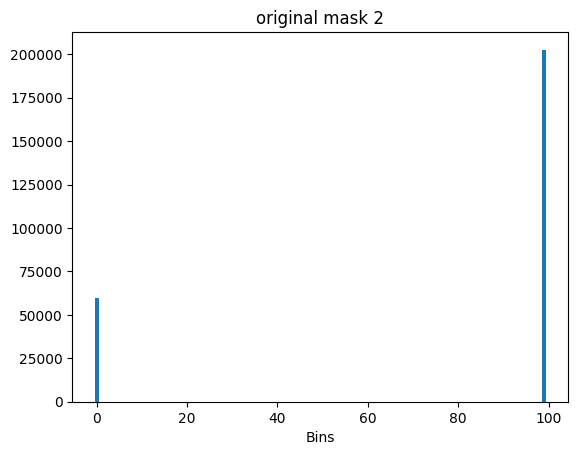

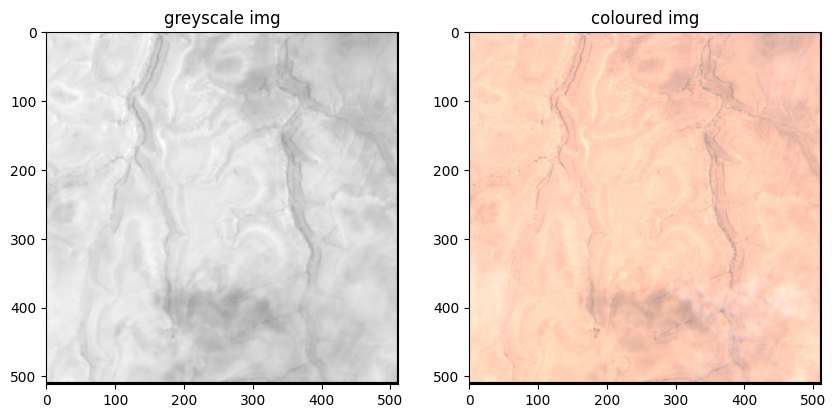

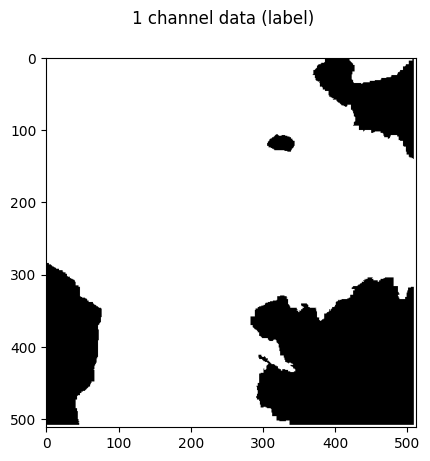

2025-10-22 16:42:18,355 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:18,356 __main__ INFO:	The number of colour channels are 1


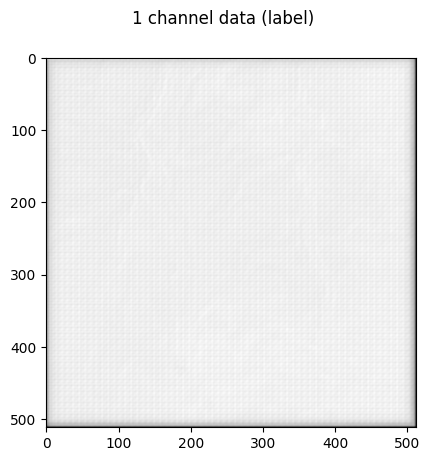

2025-10-22 16:42:18,533 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:18,534 __main__ INFO:	The number of colour channels are 1
2025-10-22 16:42:18,767 __main__ INFO:	predicted mask 3 properties: 	 min_val: 0.4465304911136627, max_val: 3.590383768081665
2025-10-22 16:42:18,768 __main__ INFO:	Tensor:			predicted mask 3
2025-10-22 16:42:18,769 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:18,770 __main__ INFO:	Output Shape:		torch.Size([1, 512, 512])
2025-10-22 16:42:18,771 __main__ INFO:	Output Size:		torch.Size([1, 512, 512])
2025-10-22 16:42:18,773 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-22 16:42:18,880 __main__ INFO:	original mask 3 properties: 	 min_val: 0.0, max_val: 1.0
2025-10-22 16:42:18,880 __main__ INFO:	Tensor:			original mask 3
2025-10-22 16:42:18,881 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:42:18,882 __main__ INFO:	Output Shape:		torch.Size([512, 512])
2025-

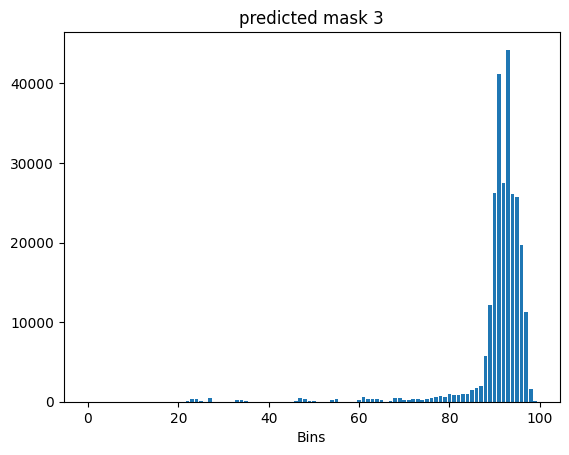

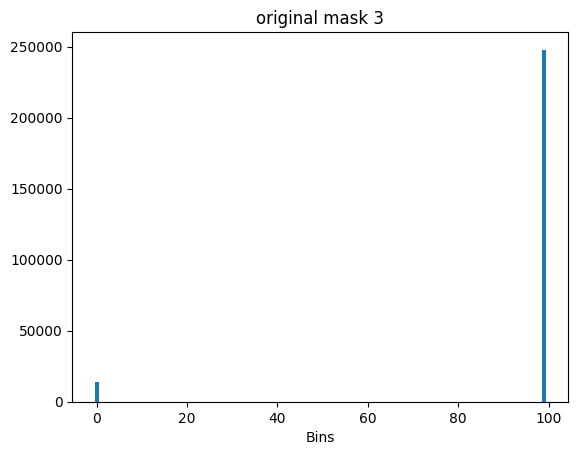

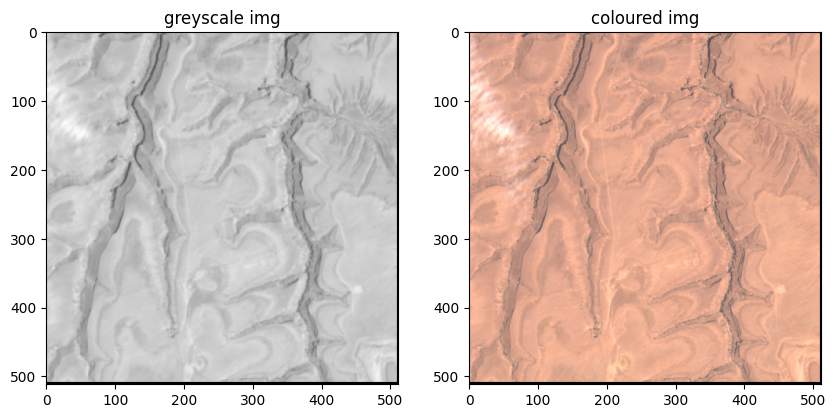

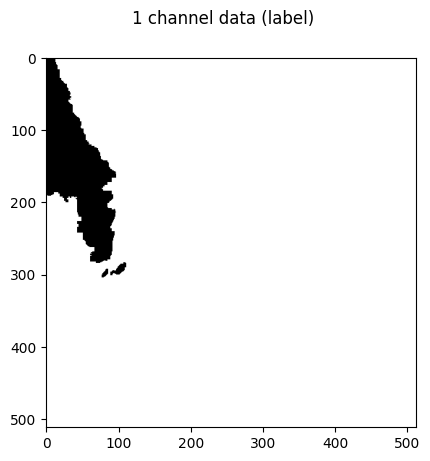

2025-10-22 16:42:19,860 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:19,860 __main__ INFO:	The number of colour channels are 1


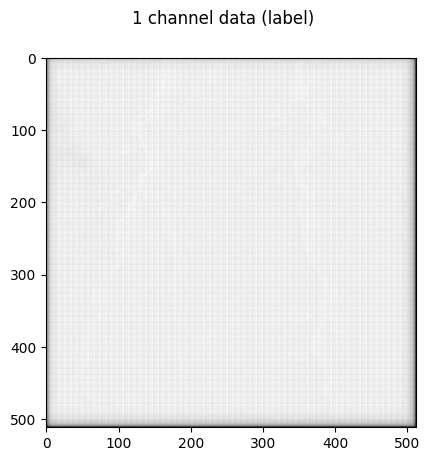

2025-10-22 16:42:20,049 __main__ INFO:	The image resolution is (512, 512)
2025-10-22 16:42:20,051 __main__ INFO:	The number of colour channels are 1


In [91]:
u_net_arch.eval()
torch.no_grad() # gradient is only required for backpropagation and training

# Random seeds https://docs.pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(27)
u_net_arch.load_state_dict(torch.load(u_net_model))

for i in range(TEST_AMOUNT):
  # Making a prediction - use to evaluate the validity of the dataset

  label_eval_predict = u_net_arch(test_img[i][:][:][:])
  histogram_tensor(label_eval_predict, "predicted mask " + str(i))
  histogram_tensor(test_label[i][:][:], "original mask " + str(i))

  # depict the image results
  view_img(i, test_img, "test_img " + str(i))
  view_img(i, test_label, "test_label " + str(i))
  mash_colour_channel(label_eval_predict)


# -------------------------------------------------------------------------------
# logger.info(f"The PREDICTED TEST LABEL from the original test image")
# mash_colour_channel(label_eval_predict)

# logger.info(f"The ORIGINAL TEST LABEL")
# mash_colour_channel(test_label[test_img_index][:][:])

# logger.info(f"The ORIGINAL TEST IMAGE")
# img = Image.fromarray(test_img[test_img_index][:][:][:].squeeze().detach().numpy() * 255)
# -------------------------------------------------------------------------------
# # Convert pytorch prediction to a PIL Image
# img = PIL.Image.fromarray(label_eval_predict.squeeze().detach().numpy() * 255)
# #img.show()
# display(img)
# -------------------------------------------------------------------------------
# todo create a overlaping bounding box over the image

# Create a Rectangle patch
# rect = matplotlib.patches.Rectangle(
#     (50, 100),
#     40,
#     30,
#     linewidth = 1,
#     edgecolor = 'r',
#     facecolor = 'none'
#   )
# create graphical method of visualising code

2025-10-22 16:20:28,974 __main__ INFO:	OG label properties: 	 min_val: 1.0, max_val: 1.0
2025-10-22 16:20:28,974 __main__ INFO:	Tensor:			OG label
2025-10-22 16:20:28,975 __main__ INFO:	Output Datatype:	torch.float32
2025-10-22 16:20:28,976 __main__ INFO:	Output Shape:		torch.Size([512, 512])
2025-10-22 16:20:28,978 __main__ INFO:	Output Size:		torch.Size([512, 512])
2025-10-22 16:20:28,978 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

/tmp/ipython-input-2958208838.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  histogram_tensor(torch.tensor(tD), "masked label a > 3")
2025-10-22 16:20:29,052 __main__ INFO:	masked label a > 3 properties: 	 min_val: 0.0, max_val: 0.0
2025-10-22 16:20:29,053 __main__ INFO:	Tensor:			masked label a > 3
2025-10-22 16:20:29,053 __main__ INFO:	Output Datatype

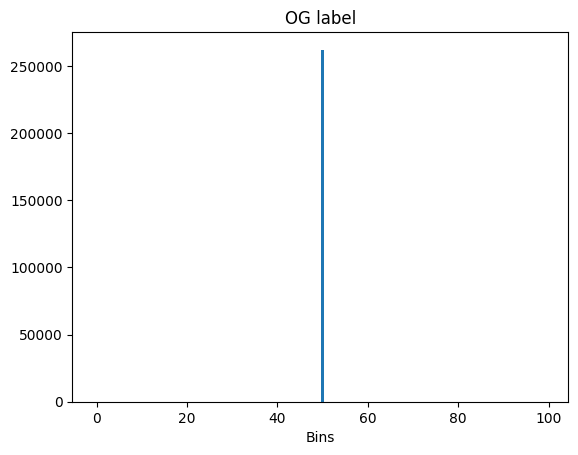

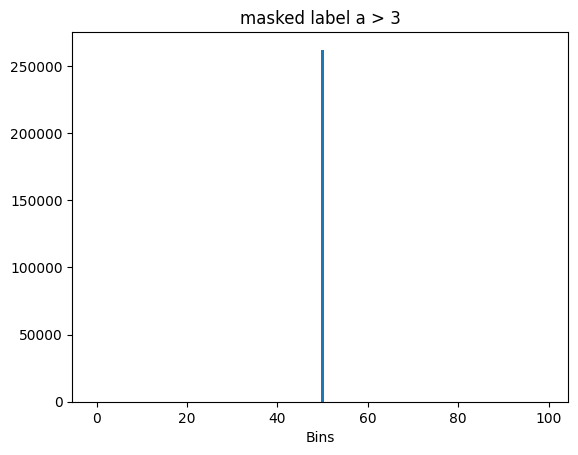

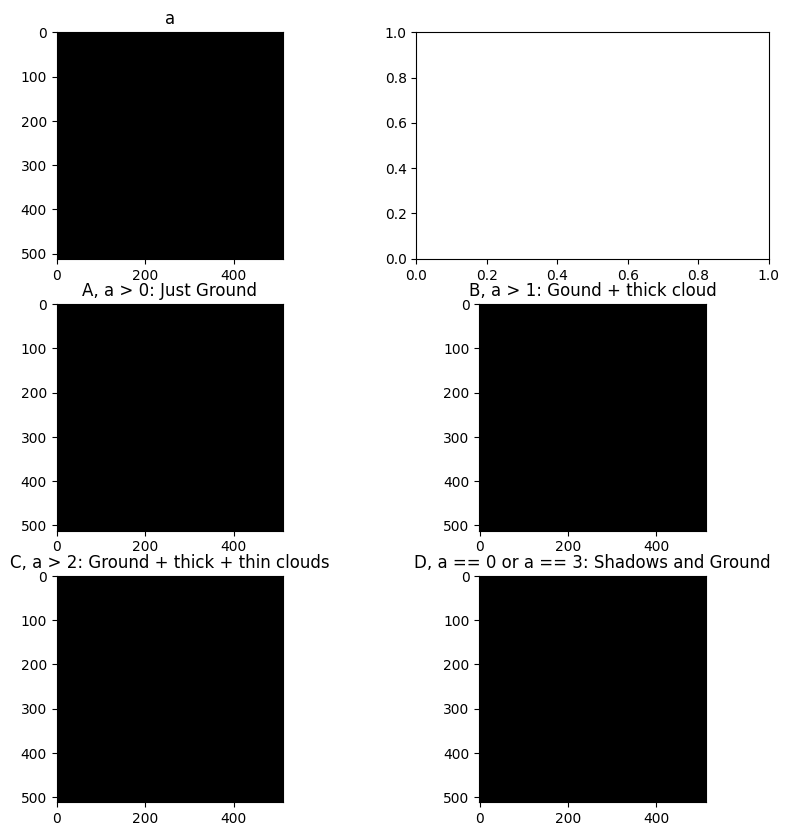

In [73]:
""" KEY:
Label description according to: https://huggingface.co/datasets/tacofoundation/cloudsen12
0 - clear ground.
1 - thick cloud.
2 - thin cloud.
3 - cloud shadow. Least useful
"""
a = test_label[1][:][:].cpu().numpy()
A = numpy.where(a > 0, 0, 1) # 1st var is result when True, 2nd is result when False
B = numpy.where(a > 1, 0, 1)
C = numpy.where(a > 2, 0, 1)
D = numpy.where(numpy.logical_not(numpy.logical_or(a == 0, a == 3)), 0, 1)
# todo investigate why the logical_not appears to output inverted output

# Histogram checking
tD = torch.tensor(D).type(torch.float32)

histogram_tensor(test_label[1][:][:], "OG label")
histogram_tensor(torch.tensor(tD), "masked label a > 3")

# create a grey scale and colour scale image - todo be further extensively modified
fig, ax = matplotlib.pyplot.subplots(3, 2, figsize = (10, 10))

ax[0, 0].set_title("a")
ax[0, 0].imshow(a)
ax[1, 0].set_title("A, a > 0: Just Ground")
ax[1, 0].imshow(A)
ax[1, 1].set_title("B, a > 1: Gound + thick cloud")
ax[1, 1].imshow(B)
ax[2, 0].set_title("C, a > 2: Ground + thick + thin clouds")
ax[2, 0].imshow(C)
ax[2, 1].set_title("D, a == 0 or a == 3: Shadows and Ground")
ax[2, 1].imshow(D)



# todo:
todo recommendations:
- use IOU - intersection over union loss class to determine missing values
- aim to minimalise cross-entropy loss - torch.nn.CrossEntropyLoss()

- Adam optimiser is recommended
- lossFunc - BCEWithLogitsLoss()

- Gradients are only used for learning or backpropagating - torch.torch_no_grad()
---
main requirements:

2. determine required images and what I should use
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)

import torchvision.transforms.functional as ttF
# Making Prelabeled image's dimensions equal the predicted image's dimensions.
label1_resize1 = ttF.resize(label1.unsqueeze(0), size = (318, 318))

```

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"**bold text**
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information
4. Unsqueeze 2 dimensional tensors to use the mash_colour_channels() functional (prints off an image in greyscale).
5. > represents a task which has been completed

## CloudSEN12+ dataset information:
(Further information about CloudSEN12+ dataset)

1. The Huggingface website: https://huggingface.co/datasets/tacofoundation/cloudsen12
Explains the overall picture of the dataset types

2. https://www.scidb.cn/en/detail?dataSetId=2036f4657b094edfbb099053d6024b08&version=V1
Explains historical dataset formatting - we are interested in  p509 has some further details. Investigate: *p509-> high -> train*

## Additional References:

Sam Hall's References:
- OBAI Cloud Detection tutorial: https://source.coop/radiantearth/cloud-cover-detection-challenge
- OBAI recommendations independent of ECSS: https://ieeexplore.ieee.org/document/10558221
- Refer to: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/